In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Reshape, BatchNormalization, Activation, LeakyReLU, Input
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import UpSampling2D
from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# For reproducibility
np.random.seed(42)

In [3]:
# Load the dataset
(X_train_init, Y_train_init), (X_test_init, Y_test_init) = cifar10.load_data()

In [4]:
X_train_init = (X_train_init.astype(np.float32) - 127.5)/127.5
X_test_init = (X_test_init.astype(np.float32) - 127.5)/127.5

In [5]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    cropped_img = np.copy(img[starty:starty+cropy, startx:startx+cropx, :])
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img[p][k] = (1, 1, 1)
            else:
                img[p][k] = img[p][k]
    return (img, cropped_img)

In [6]:
X_train = []
Y_train = []
for i in X_train_init:
    img = crop_center(i, 16, 16)
    X_train.append(img[0])
    Y_train.append(img[1])

In [7]:
X_test = []
Y_test = []
for i in X_test_init:
    img = crop_center(i, 16, 16)
    X_test.append(img[0])
    Y_test.append(img[1])

In [8]:
X_train_array = np.array(X_train)
Y_train_array = np.array(Y_train)
X_test_array = np.array(X_test)
Y_test_array = np.array(Y_test)

In [98]:
def discriminator():
    model = Sequential()
    model.add(Conv2D(64, (5, 5),padding='same',input_shape=(16, 16, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

def generator():
    #encoder
    #input = 32 x 32 x 3 (wide and thin)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = LeakyReLU(alpha=0.2), padding='same', strides=2, input_shape=(32, 32, 3)))
    model.add(BatchNormalization(momentum=0.80))
    model.add(Conv2D(64, (3, 3), activation = LeakyReLU(alpha=0.2), padding='same', strides=2))
    model.add(BatchNormalization(momentum=0.80))
    model.add(Conv2D(128, (3, 3), activation = LeakyReLU(alpha=0.2), padding='same', strides=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2048))
    #decoder
    model.add(Reshape((4,4,128)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D(size = (2,2))) # 16 x 16 x 32
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D(size = (2,2))) # 16 x 16 x 32
    model.add(Conv2D(3, (5, 5), activation='tanh', padding='same')) 
    return model


def GAN(gen, dis):
    model = Sequential()
    model.add(gen)
    dis.treinable = False
    model.add(dis)
    return model

In [99]:
d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)

model_generator = generator()
model_generator.compile(loss='binary_crossentropy', optimizer="SGD")
model_discriminator = discriminator()
model_gan = GAN(model_generator, model_discriminator)
model_gan.compile(loss='binary_crossentropy', optimizer=g_optim)
model_discriminator.treinable = True
model_discriminator.compile(loss='binary_crossentropy', optimizer=d_optim)

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [100]:
def train(train_steps=1000000, batch_size=1024):
    for i in range(train_steps):
        missing_part = Y_train_array[np.random.randint(0, Y_train_array.shape[0], size=batch_size), :, :, :]
        masked_imgs = X_train_array[np.random.randint(0, X_train_array.shape[0], size=batch_size), :, :, :]
        gen_missing_part = model_generator.predict(masked_imgs)
        all_missing_parts = np.concatenate((missing_part, gen_missing_part))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0
        d_loss = model_discriminator.train_on_batch(all_missing_parts, y)
        y = np.ones([batch_size, 1])
        
        masked_imgs = X_train_array[np.random.randint(0, X_train_array.shape[0], size=batch_size), :, :, :]
        model_discriminator.trainable = False
        a_loss = model_gan.train_on_batch(masked_imgs, y)
        model_discriminator.trainable = True
        log_mesg = "%d: [D loss: %f]" % (i, d_loss)
        log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
        if i % 1000 == 0:
                model_generator.save_weights('generator2', True)
                model_discriminator.save_weights('discriminator2', True)
        if i % 100 == 0:
            print(log_mesg)

In [101]:
train()

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.694468]  [A loss: 0.741342]
100: [D loss: 0.889374]  [A loss: 0.300118]
200: [D loss: 0.802893]  [A loss: 0.326311]
300: [D loss: 0.843761]  [A loss: 0.349314]
400: [D loss: 0.871784]  [A loss: 0.330928]
500: [D loss: 0.771462]  [A loss: 0.350956]
600: [D loss: 0.756497]  [A loss: 0.399608]
700: [D loss: 0.751051]  [A loss: 0.390238]
800: [D loss: 0.804921]  [A loss: 0.361471]
900: [D loss: 0.786671]  [A loss: 0.356012]
1000: [D loss: 0.757520]  [A loss: 0.388217]
1100: [D loss: 0.777939]  [A loss: 0.346298]
1200: [D loss: 0.759139]  [A loss: 0.375595]
1300: [D loss: 0.743726]  [A loss: 0.383033]
1400: [D loss: 0.755762]  [A loss: 0.373568]
1500: [D loss: 0.756053]  [A loss: 0.347666]
1600: [D loss: 0.804010]  [A loss: 0.334640]
1700: [D loss: 0.767410]  [A loss: 0.336098]
1800: [D loss: 0.759866]  [A loss: 0.350172]
1900: [D loss: 0.807765]  [A loss: 0.331131]
2000: [D loss: 0.860986]  [A loss: 0.303719]
2100: [D loss: 0.816784]  [A loss: 0.315924]
2200: [D loss: 0.80097

KeyboardInterrupt: 

In [102]:
def append_image(img,cropped_image, cropx, cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    img_copy = np.copy(img)
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img_copy[p][k] = cropped_image[p - starty][k - startx]
            else:
                img_copy[p][k] = img_copy[p][k]
    return img_copy

In [103]:
def print_result(img):
    prediction = model_generator.predict(np.array([img]))
    img = (img + 1) * 127.5
    prediction = (prediction + 1) * 127.5
    result = append_image(img.astype(int), prediction[0], 16, 16)
    plt.imshow(result)
    
def print_original(img, img_cropped):
    img = (img + 1) * 127.5
    img_cropped = (img_cropped + 1) * 127.5
    result = append_image(img.astype(int), img_cropped.astype(int), 16, 16)
    plt.imshow(result)

In [104]:
prediction = model_generator.predict(np.array([X_test[0]]))

In [105]:
np.amax(prediction)

0.97589195

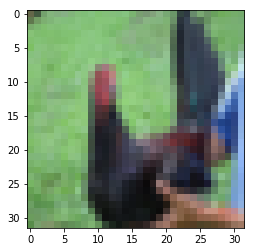

In [106]:
print_original(X_test[25], Y_test[25])

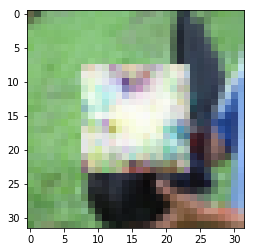

In [107]:
print_result(X_test[25])

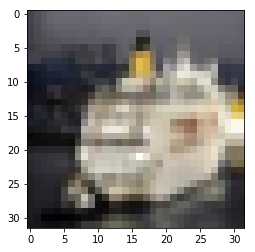

In [108]:
print_original(X_test[260], Y_test[260])

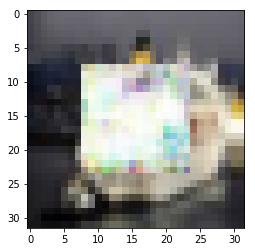

In [109]:
print_result(X_test[260])

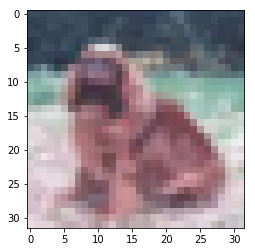

In [110]:
print_original(X_test[101], Y_test[101])

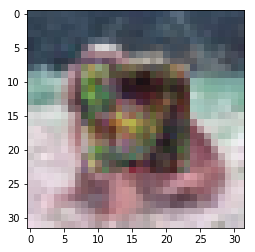

In [111]:
print_result(X_test[101])

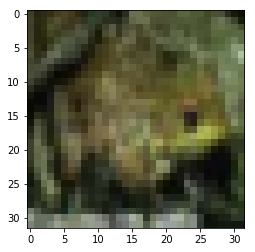

In [112]:
print_original(X_test[107], Y_test[107])

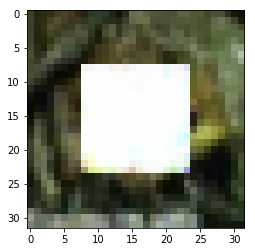

In [113]:
print_result(X_test[107])

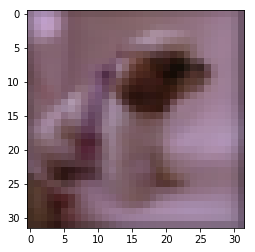

In [114]:
print_original(X_test[178], Y_test[178])

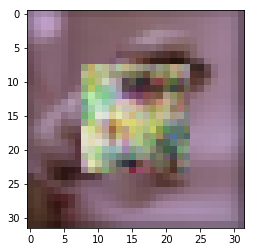

In [115]:
print_result(X_test[178])

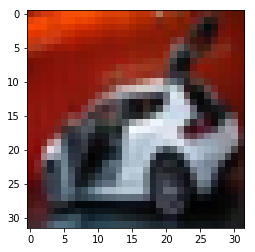

In [116]:
print_original(X_test[6], Y_test[6])

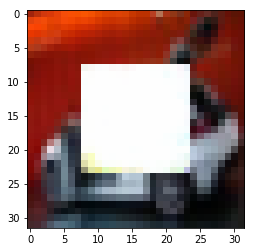

In [117]:
print_result(X_test[6])